In [2]:
# L 4-23-25

# notebooks/2_MFCC_RF_Classifier.ipynb

Note: Errors are expected:
Some of the encodings can vary
Some of the audio files are corrupted

Loading metadata...
Extracting MFCC features...


C:\Users\ranuL\AppData\Local\Temp\ipykernel_3640\558494627.py:42: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None, duration=30)
c:\Users\ranuL\Documents\GitHub\GenreWave\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Failed to process ..\data\fma_small\098\098565.mp3: 
Failed to process ..\data\fma_small\098\098567.mp3: 
Failed to process ..\data\fma_small\098\098569.mp3: 
Failed to process ..\data\fma_small\099\099134.mp3: 
Failed to process ..\data\fma_small\108\108925.mp3: 
Failed to process ..\data\fma_small\133\133297.mp3: 
Saved 7994 feature vectors and labels to ../features/mfcc_features.npz
Saved used track info to ../reports/2_MFCC_RF_Classifier/used_tracks.csv
Saved failed track info to ../reports/2_MFCC_RF_Classifier/failed_tracks.csv
Saved genre/subgenre counts to ../reports/2_MFCC_RF_Classifier/genre_subgenre_counts.csv
Training Random Forest classifier...
Saved model to ../models/rf_model.pkl
Saved test predictions to ../features/rf_test_outputs.npz

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.43      0.44      0.44       200
 Experimental       0.46      0.29      0.36       200
         Folk       0.55      0.64      0.59     

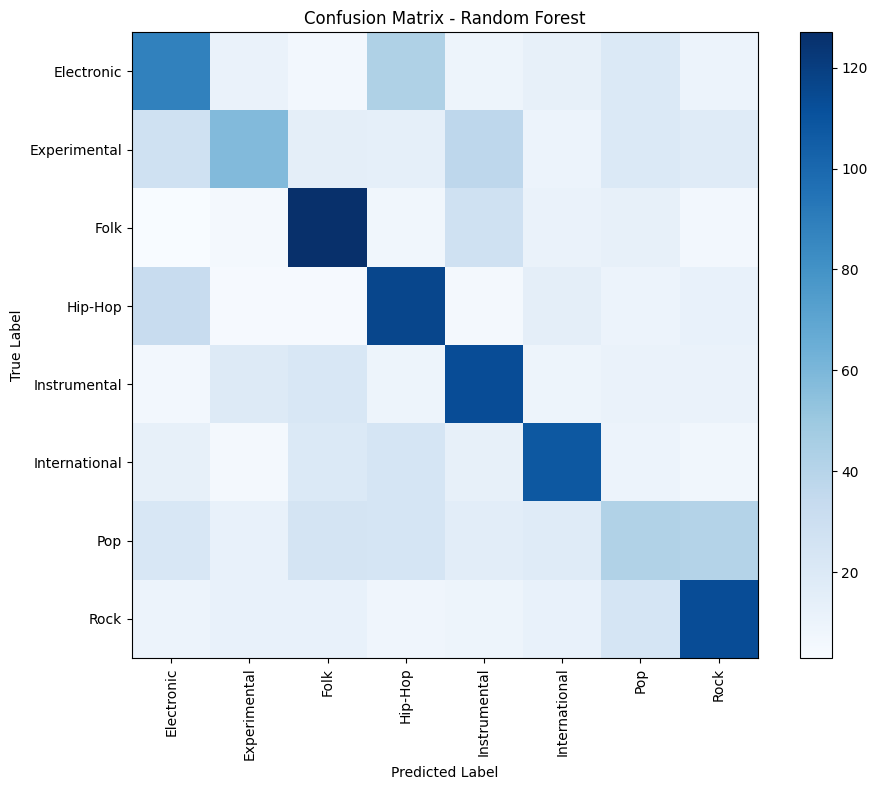

In [ ]:
# notebooks/2_MFCC_RF_Classifier.ipynb
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from collections import Counter

# Paths
METADATA_PATH = "../data/valid_track_genres.csv"
AUDIO_DIR = "../data/fma_small/"
FEATURE_SAVE_PATH = "../features/mfcc_features.npz"
MODEL_SAVE_PATH = "../models/rf_model.pkl"
TEST_OUTPUTS_PATH = "../features/rf_test_outputs.npz"
REPORT_DIR = "../reports/2_MFCC_RF_Classifier/"
os.makedirs(REPORT_DIR, exist_ok=True)

# Output paths
SUCCESS_CSV = os.path.join(REPORT_DIR, "used_tracks.csv")
FAILED_CSV = os.path.join(REPORT_DIR, "failed_tracks.csv")
GENRE_COUNTS_CSV = os.path.join(REPORT_DIR, "genre_subgenre_counts.csv")
FULL_CLASS_REPORT_TXT = os.path.join(
    REPORT_DIR, "rf_classification_report.txt")

# Load track genre metadata


def load_metadata(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['genre_top'])
    return df

# Extract MFCCs from a single audio file


def extract_mfcc(path, n_mfcc=20):
    try:
        y, sr = librosa.load(path, sr=None, duration=30)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfcc, axis=1), np.std(mfcc, axis=1)
    except Exception as e:
        print(f"Failed to process {path}: {e}")
        return None, None

# Main pipeline


def main():
    print("Note: Errors are expected:")
    print("Some of the encodings can vary")
    print("Some of the audio files are corrupted\n")

    print("Loading metadata...")
    df = load_metadata(METADATA_PATH)
    track_ids = df['track_id'].astype(str).str.zfill(6).tolist()
    labels = df['genre_top'].tolist()
    subgenres_list = df['subgenres'].apply(eval).tolist()

    print("Extracting MFCC features...")
    X, y, used_info = [], [], []
    failed_info = []

    for idx, track_id in enumerate(track_ids):
        subfolder = track_id[:3]
        filename = f"{track_id}.mp3"
        filepath = os.path.normpath(
            os.path.join(AUDIO_DIR, subfolder, filename))

        genre = labels[idx]
        subgenres = subgenres_list[idx]

        if not os.path.isfile(filepath):
            failed_info.append({
                'track_id': track_id,
                'reason': 'file not found',
                'genre': genre,
                'subgenres': subgenres
            })
            continue

        mfcc_mean, mfcc_std = extract_mfcc(filepath)
        if mfcc_mean is not None:
            feature_vector = np.concatenate([mfcc_mean, mfcc_std])
            X.append(feature_vector)
            y.append(genre)
            used_info.append({
                'track_id': track_id,
                'genre': genre,
                'subgenres': subgenres
            })
        else:
            failed_info.append({
                'track_id': track_id,
                'reason': 'processing error',
                'genre': genre,
                'subgenres': subgenres
            })

    # Convert to arrays and save
    X = np.array(X)
    y = np.array(y)
    np.savez(FEATURE_SAVE_PATH, X=X, y=y)
    print(f"Saved {len(X)} feature vectors and labels to {FEATURE_SAVE_PATH}")

    # Save usage and error logs
    pd.DataFrame(used_info).to_csv(SUCCESS_CSV, index=False)
    pd.DataFrame(failed_info).to_csv(FAILED_CSV, index=False)
    print(f"Saved used track info to {SUCCESS_CSV}")
    print(f"Saved failed track info to {FAILED_CSV}")

    # Count genre and subgenre stats
    genre_counts = Counter([row['genre'] for row in used_info])
    all_subgenres = [sub for row in used_info for sub in row['subgenres']]
    subgenre_counts = Counter(all_subgenres)

    genre_df = pd.DataFrame(list(genre_counts.items()),
                            columns=["label", "count"])
    genre_df["type"] = "genre"

    subgenre_df = pd.DataFrame(
        list(subgenre_counts.items()), columns=["label", "count"])
    subgenre_df["type"] = "subgenre"

    pd.concat([genre_df, subgenre_df], ignore_index=True).to_csv(
        GENRE_COUNTS_CSV, index=False)
    print(f"Saved genre/subgenre counts to {GENRE_COUNTS_CSV}")

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    print("Training Random Forest classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    joblib.dump(clf, MODEL_SAVE_PATH)
    print(f"Saved model to {MODEL_SAVE_PATH}")

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    np.savez(TEST_OUTPUTS_PATH, X_test=X_test, y_test=y_test, y_pred=y_pred)
    print(f"Saved test predictions to {TEST_OUTPUTS_PATH}")

    print("\nClassification Report:")
    labels_sorted = sorted(set(y))
    report = classification_report(
        y_test, y_pred, labels=labels_sorted, zero_division=0)
    print(report)

    with open(FULL_CLASS_REPORT_TXT, "w") as f:
        f.write(report)
    print(f"Saved classification report to {FULL_CLASS_REPORT_TXT}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix - Random Forest")
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(labels_sorted)),
               labels=labels_sorted, rotation=90)
    plt.yticks(ticks=np.arange(len(labels_sorted)), labels=labels_sorted)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig(os.path.join(REPORT_DIR, "rf_confusion_matrix.png"))
    plt.show()


if __name__ == "__main__":
    main()